In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from neural_network import *

# read dataset
dataset_path = 'sonar.all-data'
# number of features
n_features = 60
# name the feature and target columns
data = pd.read_csv(dataset_path, sep=",", names=np.append(np.arange(n_features),['Y']))

In [2]:
# convert ir to dataframe
trainset = pd.DataFrame(data)

# transform Minerals in 0 and Rocks in 1
trainset = trainset.replace('M',0)
trainset = trainset.replace('R',1)

In [3]:
import numpy as np
from tqdm import tqdm
import pickle
import pandas as pd

class NNetwork:
    def __init__(self, n_input, hidden_layer_size, n_cat):
        self.n_input = n_input
        self.n_hidden_layers = 2
        self.hidden_layer_size = hidden_layer_size
        self.n_cat = n_cat
        
        # initialize weights
        self.w_1 = np.random.randn(self.hidden_layer_size, self.n_input) / np.sqrt(self.n_input)
        self.w_2 = np.random.randn(self.hidden_layer_size, self.hidden_layer_size) / np.sqrt(self.hidden_layer_size)
        self.w_3 = np.random.randn(self.n_cat, self.hidden_layer_size) / np.sqrt(self.hidden_layer_size)

        # initialize biases
        self.b_1 = np.zeros((self.hidden_layer_size, 1))
        self.b_2 = np.zeros((self.hidden_layer_size, 1))
        self.b_3 = np.zeros((self.n_cat, 1))
        
    def train(self, trainset_i, n_epochs, alpha, n_samples):
        """
        train a fully connected neural network using the specified train_set (dataframe)
        """
        if (trainset_i).shape[1]-1 != self.n_input:
            raise ValueError(u"X_train size has to be the same as the Network inputs")

        i = 0
        cost = np.zeros(n_epochs)

        while i < n_epochs:            
            subset = trainset_i.sample(n_samples)
            for index, element in trainset_i.iterrows():
                
                X_train = element[:-1]
                Y_train = element[self.n_input]
                dim1 = X_train.shape
                
                element = X_train.values.reshape((dim1[0], 1))
             
                z_1 = self.w_1.dot(element) + self.b_1    # input weight
                a_1 = self.__relu(z_1)                   # pass through ReLU non-linearity

                # pass trough the hidden layer 1
                z_2 = self.w_2.dot(a_1) + self.b_2
                a_2 = self.__relu(z_2)               

                # pass though the hidden layer 2
                z_3 = self.w_3.dot(a_2) + self.b_3
                # Activation function
                a_3 = self.__sigmoid(z_3) # predict class probabilities with the softmax activation function
                # Loss
                Yh = a_3
                
                
                loss = self.__squared_loss(Yh, Y_train)
                cost[i] += loss
               
                # derivative of the loss function w.r.t. output a_3
                dLoss_Yh = Yh - Y_train

                dLoss_z3 = dLoss_Yh * self.__dev_sigmoid(z_3)
                dLoss_a2 = np.dot(self.w_3.T, dLoss_z3)
                dLoss_w3 = 1./a_2.shape[0] * np.dot(dLoss_z3, a_2.T)
                dLoss_b3 = 1./a_2.shape[0] * np.dot(dLoss_z3, np.ones([dLoss_z3.shape[1],1]))
                
                # 2nd layer
                dLoss_z2 = dLoss_a2 * self.__relu_derivative(z_2)        
                dLoss_a1 = np.dot(self.w_2.T, dLoss_z2)
                dLoss_w2 = 1./a_1.shape[1] * np.dot(dLoss_z2, a_1.T)
                dLoss_b2 = 1./a_1.shape[1] * np.dot(dLoss_z2, np.ones([dLoss_z2.shape[1],1]))
                
                # 1st layer
                dLoss_z1 = dLoss_a1 * self.__relu_derivative(z_1)        
                dLoss_a0 = np.dot(self.w_1.T,dLoss_z1)
                dLoss_w1 = 1./element.shape[1] * np.dot(dLoss_z1, element.T)
                dLoss_b1 = 1./element.shape[1] * np.dot(dLoss_z1, np.ones([dLoss_z1.shape[1],1]))

                # Update the weight and biases
                self.w_1 = self.w_1 - dLoss_w1 * alpha
                self.b_1 = self.b_1 - dLoss_b1 * alpha
                self.w_2 = self.w_2 - dLoss_w2 * alpha
                self.b_2 = self.b_2 - dLoss_b2 * alpha
                self.w_3 = self.w_3 - dLoss_w3 * alpha
                self.b_3 = self.b_3 - dLoss_b3 * alpha
                
                params = [self.w_1, self.b_1, self.w_2, self.b_2, self.w_3, self.b_3]

            i += 1
        to_save = [params, cost/float(n_samples)]
    
        with open('model', 'wb') as file:
            pickle.dump(to_save, file)

        return cost
    
    def predict(self, element, w1, b1, w2, b2, w3, b3):
        '''
        Make predictions with trained filters/weights. 
        '''
        element = element[:-1]
        fc = element.values.reshape((60, 1)) # flatten pooled layer

        z1 = w1.dot(fc) + b1 # first dense layer
        a1 = self.__relu(z1) # pass through ReLU non-linearity

        z2 = w2.dot(a1) + b2 # first dense layer
        a2 = self.__relu(z2) # pass through ReLU non-linearity

        out = w3.dot(a2) + b3 # second dense layer
        probs = self.__sigmoid(out) # predict class probabilities with the softmax activation function

        return (np.argmax(probs), np.max(probs))
    
    #### private methods
    
    def __squared_loss(self, probs, labels):
        return np.sum((probs - labels)**2)*0.5
    
    def __relu_derivative(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    def __relu(self, X):
        return np.maximum(0,X)

    def __sigmoid(self, Z):
        return 1/(1+np.exp(-Z))
    
    def __dev_sigmoid(self, Z):
        s = 1/(1+np.exp(-Z))
        dZ = s * (1-s)
        return dZ



In [4]:
# Initialize the network:
n_neurons_per_hidden_layer = 180
n_categories = 2
network = NNetwork(n_features, n_neurons_per_hidden_layer, n_categories)

In [5]:
# train the network
# trainset with features in the first 60 columns and the labels in the last one
n_epoch = 500
alpha = 0.1
bach_size = 32

cost = network.train(trainset, n_epoch, alpha, bach_size)

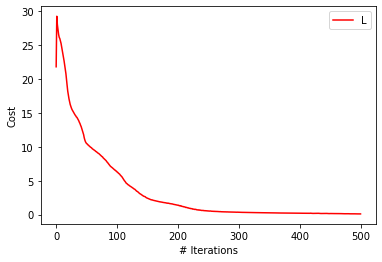

In [6]:
# Plot cost 
plt.plot(cost, 'r')
plt.xlabel('# Iterations')
plt.ylabel('Cost')
plt.legend('Loss', loc='upper right')
plt.show()

In [7]:
# load saved parameters
params, cost = pickle.load(open('model', 'rb'))
[w_1, b_1, w_2, b_2, w_3, b_3] = params

# predict using the learned model
prediction = np.array([])
for i in np.arange(trainset.shape[0]):
    prediction = np.append(prediction, network.predict(trainset.iloc[i], w_1, b_1, w_2, b_2, w_3, b_3)[0])
print(prediction)

[1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


In [8]:
TP = TN = FP = FN = 0
for i in np.arange(len(prediction)):
    TP += trainset["Y"][i]==prediction[i] and trainset["Y"][i] == 1
    TN += trainset["Y"][i]==prediction[i] and trainset["Y"][i] == 0
    FP += not(trainset["Y"][i]==prediction[i]) and trainset["Y"][i] == 1
    FN += not(trainset["Y"][i]==prediction[i]) and trainset["Y"][i] == 0
Accuracy = (TP + TN) / float(len(prediction))
Precision = TP / float(TP + FP)
Recall = TP / float(TP + FN)

print("Accuracy", Accuracy)
print("Precision", Precision)
print("Recall", Recall)

Accuracy 0.6009615384615384
Precision 0.4536082474226804
Recall 0.5945945945945946
